In [31]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [32]:
batch_size = 32
img_height = 224
img_width = 224

In [33]:
tool_train_path = r'E:\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images'

In [34]:
tool_train_ds = tf.keras.utils.image_dataset_from_directory(
    tool_train_path,
    shuffle='True',
    validation_split=0.2, # 20% of the data for validation
    subset="training",    # 80% of the data for training
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# Load validation/testing dataset (remaining 30% of the data)
tool_val_ds = tf.keras.utils.image_dataset_from_directory(
    tool_train_path,
    shuffle='True',
    validation_split=0.2, # 30% for validation/testing
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 160 files belonging to 4 classes.
Using 128 files for training.
Found 160 files belonging to 4 classes.
Using 32 files for validation.


In [35]:
tool_class_names = tool_val_ds.class_names
print(tool_class_names)

['BF', 'GF', 'N', 'TF']


In [36]:
normalization_layer = layers.Rescaling(1./255)

tool_normalized_ds = tool_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_normalized_ds = tool_val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(tool_normalized_ds))

In [37]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Optionally, modify the base model to end at a specific layer
vgg_base = Model(inputs=vgg_base.inputs, outputs=vgg_base.layers[-5].output)

# Freeze the layers of VGG16 to prevent them from being trained
for layer in vgg_base.layers:
    layer.trainable = False

In [38]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, LSTM, TimeDistributed, Reshape

In [39]:
new_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4)
])

In [40]:
# Compile the new model
new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001)

history = new_model.fit(
    tool_train_ds,
    validation_data=tool_val_ds,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2167 - loss: 4379.7588 - val_accuracy: 0.1250 - val_loss: 5867.3164
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2042 - loss: 3188.6221 - val_accuracy: 0.2812 - val_loss: 1761.0615
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3281 - loss: 1538.3198 - val_accuracy: 0.2812 - val_loss: 2391.8999
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4958 - loss: 1225.6106 - val_accuracy: 0.3438 - val_loss: 690.6870
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.2833 - loss: 934.4921 - val_accuracy: 0.7188 - val_loss: 52.8349
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7792 - loss: 39.2081 - val_accuracy: 0.5312 - val_loss: 262.7338
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7198 - loss: 163.8916 - val_accuracy: 0.6562 - val_loss: 251.2256
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7906 - loss: 89.0702 - val_accuracy

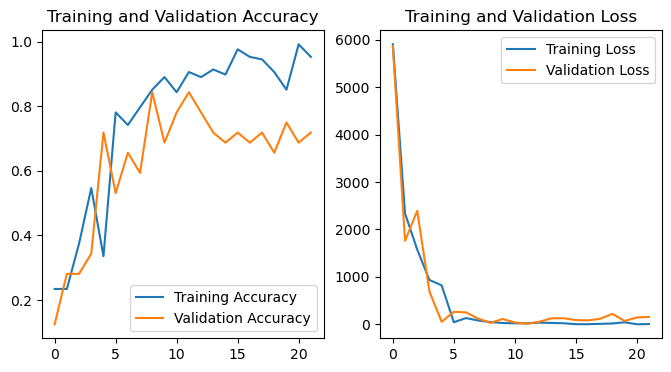

In [46]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_metrics(history)


In [43]:
val_loss, val_accuracy = new_model.evaluate(tool_val_ds)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8438 - loss: 12.2452
Validation Loss: 12.245227813720703
Validation Accuracy: 0.84375


In [44]:
from sklearn.metrics import confusion_matrix, classification_report

val_predictions = np.argmax(new_model.predict(tool_val_ds), axis=1)
val_labels = np.concatenate([y for x, y in tool_val_ds], axis=0)

cm = confusion_matrix(val_labels, val_predictions)
cr = classification_report(val_labels, val_predictions, target_names=tool_class_names)

print('Confusion Matrix')
print(cm)
print('Classification Report')
print(cr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix
[[0 3 1 0]
 [2 1 4 1]
 [0 3 3 5]
 [3 0 3 3]]
Classification Report
              precision    recall  f1-score   support

          BF       0.00      0.00      0.00         4
          GF       0.14      0.12      0.13         8
           N       0.27      0.27      0.27        11
          TF       0.33      0.33      0.33         9

    accuracy                           0.22        32
   macro avg       0.19      0.18      0.18        32
weighted avg       0.22      0.22      0.22        32

